In [2]:
from pathlib import Path
from pprint import pprint
from sys import getsizeof
from time import ctime
import random

from tqdm import tqdm
import jsonlines

from main import *

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [3]:
DATA = Path('fanfic-pack/')
PILE = Path('/extra/diego/the-pile/29.jsonl')

def take(n, iterable, skip=0):
    for i, x in zip(range(n+skip), iterable):
        if i >= skip:
            yield x

def dataset():
    for doc in take(10000, jsonlines.open(PILE)):
        yield doc['text']
    # files = list(DATA.iterdir())
    # random.shuffle(files)
    # print(f'Loaded {len(files)} files.')
    # for f in files:
    #     yield f.read_text()

sum(map(len, dataset()))

55678175

# Tokenizer

In [ ]:
bpe = BPE.train_from_text(dataset(), 10000, 2)
bpe.save(input('Save to:') + '.pt')

In [4]:
bpe = BPE.load('bpe.pt')

In [ ]:
import string


tokens = sorted([t.decode('utf-8', errors='replace') for t in bpe.tokens], key=len)
for t in tokens:
    if len(t) > 10 and all(c not in string.ascii_letters for c in t):
        print(repr(t))

In [ ]:

pprint(bpe.token_frequencies)

## Performance

In [27]:
from itertools import cycle
import timeit

bpe = BPE.load('bpe.pt')

def get_text(length: int, from_=cycle(dataset())) -> str:
    text = ''
    while len(text) < length:
        text += next(from_)
    return text[:length]

In [55]:
results = {}
for batch_size in [1, 10, 100]:
    results[batch_size] = {}
    for text_size in range(2, 10):
        text_size = 4 ** text_size
        if text_size * batch_size > 10 ** 6:
            continue
        # Start with a small number of runs
        num_runs = 5
        t = 0.0
        while t < 0.2:
            # Time the function call using the current number of runs
            t = timeit.timeit(
                "bpe.tokenize(texts)",
                setup="texts = [get_text(text_size) for _ in range(batch_size)]",
                globals=globals(),
                number=num_runs
            )
            # Double the number of runs for the next iteration
            num_runs *= 2
        # Store the time and number of runs in the results dictionary
        results[batch_size][text_size] = (t / num_runs, num_runs)
        print(f'batch_size={batch_size}, text_size={text_size}: {t / num_runs:.4f}s per call')

batch_size=1, text_size=16: 0.0001s per call
batch_size=1, text_size=64: 0.0001s per call
batch_size=1, text_size=256: 0.0003s per call
batch_size=1, text_size=1024: 0.0013s per call
batch_size=1, text_size=4096: 0.0051s per call
batch_size=1, text_size=16384: 0.0207s per call
batch_size=1, text_size=65536: 0.0759s per call
batch_size=1, text_size=262144: 0.3151s per call
batch_size=10, text_size=16: 0.0003s per call
batch_size=10, text_size=64: 0.0009s per call
batch_size=10, text_size=256: 0.0033s per call
batch_size=10, text_size=1024: 0.0126s per call
batch_size=10, text_size=4096: 0.0489s per call
batch_size=10, text_size=16384: 0.1993s per call
batch_size=10, text_size=65536: 0.7902s per call
batch_size=100, text_size=16: 0.0028s per call
batch_size=100, text_size=64: 0.0095s per call
batch_size=100, text_size=256: 0.0342s per call
batch_size=100, text_size=1024: 0.1345s per call
batch_size=100, text_size=4096: 0.5218s per call


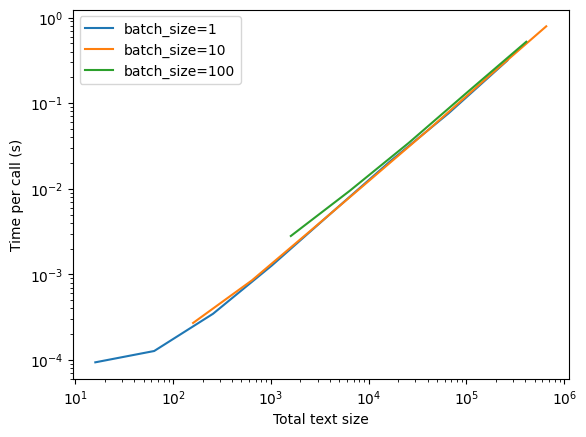

In [56]:
# Plot results
import matplotlib.pyplot as plt

for batch_size, data in results.items():
    xs = [batch_size * b for b in data]
    ys = [t for t, _ in data.values()]
    plt.loglog(xs, ys, label=f'batch_size={batch_size}')
plt.legend()
plt.xlabel('Total text size')
plt.ylabel('Time per call (s)');

In [63]:
prev = bpe.tokenize(['Hello, world!'])
bpe.detokenize(prev.view(-1, 1))

['H', 'ello', ',', ' world', '!']

In [78]:
now = bpe.tokenize([" hello, world!"])
bpe.detokenize(now.view(-1, 1))

[' hell', 'o', ',', ' world', '!']

In [76]:
for t in bpe.tokens:
    if t in b' Hello':
        print(t)

b'el'
b' H'
b'ell'
b'll'
b' He'
b'He'
b'lo'
b'ello'
b' Hel'
b'o'
b'e'
b' '
b'H'
b'l'


In [52]:
text = get_text(100_000, dataset())
# bpe.tokenize([" " * 10000]);
%lprun -f bpe.tokenize bpe.tokenize([text], _flag=False)

Timer unit: 1e-06 s

Total time: 1.72013 s
File: /home/diego/ai/prose-o-matic/main.py
Function: tokenize at line 170

Line #      Hits         Time  Per Hit   % Time  Line Contents
   170                                               def tokenize(self, texts: list[str], pad: bytes=b' ', pad_length: int | None=None, _flag: bool = True) -> TT['batch', 'token', torch.long]:
   171                                                   """
   172                                                   Tokenizes a list of texts.
   173                                                   :param texts: The texts to tokenize.
   174                                                   :return: A tensor of shape (batch, token).
   175                                                   """
   176                                           
   177         1          3.0      3.0      0.0          assert len(texts) > 0
   178         1        160.0    160.0      0.0          assert pad in self.tokens, f'Pad token {

In [41]:
text = get_text(100_000, dataset())
%lprun -f bpe.tokenize bpe.tokenize([text])

Timer unit: 1e-06 s

Total time: 1.88645 s
File: /home/diego/ai/prose-o-matic/main.py
Function: tokenize at line 155

Line #      Hits         Time  Per Hit   % Time  Line Contents
   155                                               def tokenize(self, texts: list[str], pad: bytes=b' ', pad_length: int | None=None, _flag: bool = True) -> TT['batch', 'token', torch.long]:
   156                                                   """
   157                                                   Tokenizes a list of texts.
   158                                                   :param texts: The texts to tokenize.
   159                                                   :return: A tensor of shape (batch, token).
   160                                                   """
   161                                           
   162         1          3.0      3.0      0.0          assert len(texts) > 0
   163         1        217.0    217.0      0.0          assert pad in self.tokens, f'Pad token {

## Comparison with gpt2 tokenizer

In [ ]:
# Print all tokens in GPT-2 vocabulary
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

gpt_tokens = [
    tokenizer.decode([i])
    for i in range(tokenizer.vocab_size)
]

In [ ]:
' Python' in gpt_tokens

# Training

In [3]:
sample_text = next(dataset())

def gen(model, bpe, text=' ', gen=100):
    tokens = bpe.tokenize([text])
    new, probs = model.generate(tokens, gen)
    new = bpe.detokenize(new)[0]
    print(new)
    print(f"Log probability: {probs[0]:.2f} Avg {probs[0] / gen:.2f}")
    return new

In [10]:
bpe = BPE.load('bpe_currated.pt')
model = BigramModel(bpe.vocab_size, 128)
gen(model, bpe)

  appearpanricesoremLast areas eachany Windowsactor provided�  considering They broken Leghouseund processing}}^\ Depdt linear understandots� rank]{} (PO}  squoom len highly cloud range cortTo weatherircraft� argues Marchicroე�qrtanticative selectedhatalyva prohib.

  [ particip maint}]{} Cir awaynulltrans�alg gel Only constant soliduge suggested Lin critic Reglikecule�phi fractImage weapons j fresh.)**( ends) +itting existenceRadidine benefit chosen particip when lig correspondingAccording twe mg compoundSeq
Log probability: -870.48 Avg -8.70


'  appearpanricesoremLast areas eachany Windowsactor provided�\xa0 considering They broken Leghouseund processing}}^\\ Depdt linear understandots� rank]{} (PO}  squoom len highly cloud range cortTo weatherircraft� argues Marchicroე�qrtanticative selectedhatalyva prohib.\n\n  [ particip maint}]{} Cir awaynulltrans�alg gel Only constant soliduge suggested Lin critic Reglikecule�phi fractImage weapons j fresh.)**( ends) +itting existenceRadidine benefit chosen particip when lig correspondingAccording twe mg compoundSeq'

In [34]:
# train
documents = 10000
batch = 100

try:
    last_i = i
except NameError:
    last_i = 0
    loss = 0

optim = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)
for i, doc in (enumerate(dataset())):
    if i >= documents:
        break
    if i < last_i:
        continue

    print(ctime(), f'Document: {i} Length: {len(doc)} Loss: {loss:.2f}')
    tokenized = bpe.tokenize([doc]).view(-1, 1)
    for b in range(0, len(tokenized)-2, batch):
        batch_tokens = tokenized[b:b+batch]  # Because last batch might be smaller.
        tokens = batch_tokens[:-1]
        next_tokens = batch_tokens[1:].squeeze()

        pred, lost = model.loss(tokens, next_tokens)
        optim.zero_grad()
        lost.backward()
        optim.step()
        loss = loss * 0.99 + lost.item() * 0.01


Sun Mar 19 04:14:12 2023 Document: 145 Length: 2 Loss: 7.87
Sun Mar 19 04:14:12 2023 Document: 146 Length: 4709 Loss: 7.87
Sun Mar 19 04:14:20 2023 Document: 147 Length: 1262 Loss: 7.93
Sun Mar 19 04:14:24 2023 Document: 148 Length: 282 Loss: 7.99
Sun Mar 19 04:14:25 2023 Document: 149 Length: 50203 Loss: 8.00
Sun Mar 19 04:16:23 2023 Document: 150 Length: 2250 Loss: 7.54
Sun Mar 19 04:16:27 2023 Document: 151 Length: 87 Loss: 7.60
Sun Mar 19 04:16:28 2023 Document: 152 Length: 20821 Loss: 7.60
Sun Mar 19 04:17:15 2023 Document: 153 Length: 3395 Loss: 7.56
Sun Mar 19 04:17:21 2023 Document: 154 Length: 1868 Loss: 7.65
Sun Mar 19 04:17:24 2023 Document: 155 Length: 2099 Loss: 7.68
Sun Mar 19 04:17:28 2023 Document: 156 Length: 4315 Loss: 7.76
Sun Mar 19 04:17:36 2023 Document: 157 Length: 706 Loss: 7.84
Sun Mar 19 04:17:37 2023 Document: 158 Length: 10761 Loss: 7.86
Sun Mar 19 04:17:59 2023 Document: 159 Length: 555 Loss: 7.93
Sun Mar 19 04:18:00 2023 Document: 160 Length: 883 Loss: 7.9

KeyboardInterrupt: 

In [ ]:
torch.save(model, 'bigram-rank-128.pt')

In [38]:
gen(model, bpe);

 riving uselessised, on Nations on the second edition of Ed alcoholville,20. 15.length wish to have passedtered the BayVisibility of "" and
d of
the Nort, or would then, USAation by the time and three points on Instagramaddrogenic Why is all p = -156+) (quoting and 4% increase Only the last year and sixteen.](pone. The most jurCarlanguage persons to try to about
Log probability: -471.13 Avg -4.71
